# MyAcrobot
my custom acrobot rl model for learning, this will have an extended custom environment

### Create my virutal environment

#

pip install virtualenv
virtualenv myenv
source myenv/bin/activate
pip install numpy pandas matplotlib
pip install ipykernel
python -m ipykernel install --user --name=myenv --display-name "Python (myenv)"



pip install virtualenv virtualenv myenv source myenv/bin/activate pip install numpy pandas matplotlib pip install ipykernel python -m ipykernel install --user --name=myenv --display-name "Python (myenv)" 

## Model Code

In [19]:
!pip install gymnasium
!pip install gymnasium[classic-control]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 172.6 MB/s eta 0:00:00


state is  (array([ 0.9983533 , -0.05736414,  0.9950423 ,  0.09945264,  0.04194031,
       -0.05998954], dtype=float32), {})


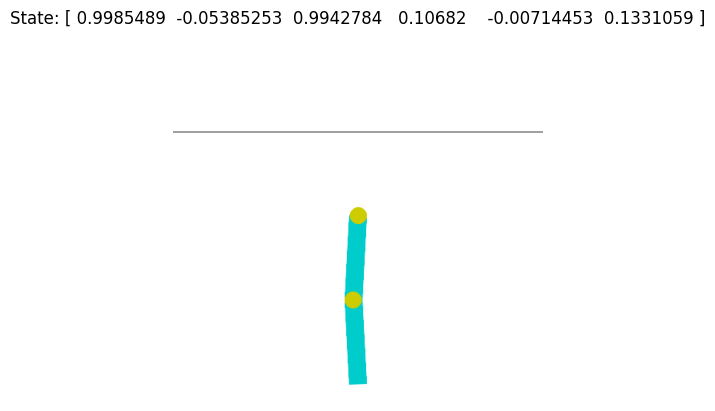

state is  [ 0.9985489  -0.05385253  0.9942784   0.10682    -0.00714453  0.1331059 ]


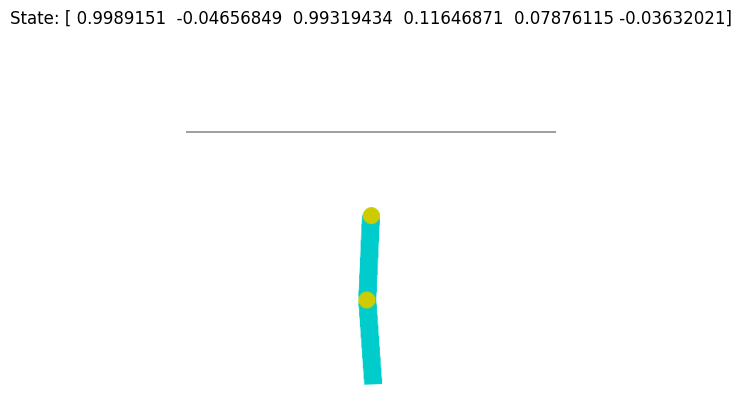

state is  [ 0.9989151  -0.04656849  0.99319434  0.11646871  0.07876115 -0.03632021]


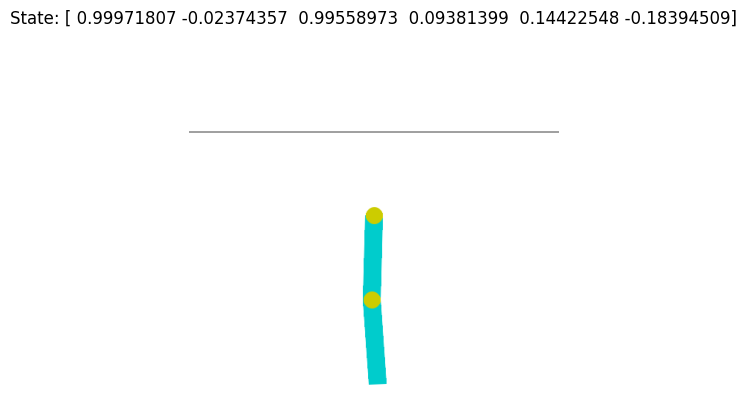

state is  [ 0.99971807 -0.02374357  0.99558973  0.09381399  0.14422548 -0.18394509]


In [8]:
import gymnasium as gym
import matplotlib.pyplot as plt

env = gym.make('Acrobot-v1', render_mode='rgb_array')  # Create the environment

state = env.reset()
print("state is ", state)

# Run a simple loop to interact with the environment
for _ in range(3):
    action = env.action_space.sample()  # Sample a random action
    state, reward, done, info, _ = env.step(action)  # Take a step in the environment
    
    # Render the environment and get the image
    img = env.render()

    # # Plot the image using Matplotlib
    plt.imshow(img)
    plt.title(f'State: {state}')
    plt.axis('off')  # Turn off the axis
    plt.show()

    print("state is ", state)
    if done:
        state = env.reset()  # Reset the environment if done

env.close()  # Close the environment


Initial state: (array([ 9.9970800e-01,  2.4163572e-02,  9.9638206e-01, -8.4987283e-02,
        3.6662940e-02, -8.5258915e-04], dtype=float32), {})
State: [ 0.99964356  0.02669787  0.99725956 -0.0739823  -0.01142294  0.10962421]


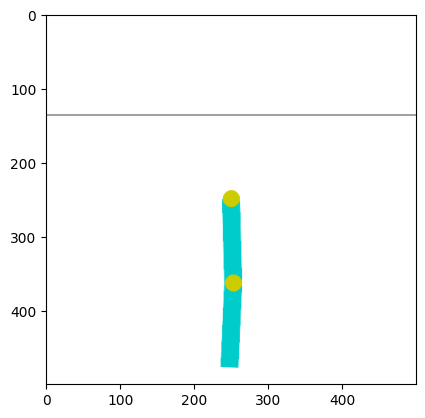

State: [ 0.9994457   0.03329246  0.9970257  -0.07706945  0.07582288 -0.13874911]
State: [ 0.9984638   0.05540808  0.99198824 -0.12633021  0.13937066 -0.3442176 ]
State: [ 0.99631727  0.0857435   0.97839975 -0.20672187  0.15594749 -0.45243794]
State: [ 0.99350023  0.11383034  0.9555198  -0.2949269   0.11791573 -0.43951663]
State: [ 0.9945771   0.10400168  0.9524752  -0.3046162  -0.21441878  0.33708426]
State: [ 0.99897075  0.04535891  0.9790924  -0.20341578 -0.3590016   0.68391764]
State: [ 0.9989799  -0.04515617  0.99988097 -0.0154277  -0.52220297  1.1635898 ]
State: [ 0.98852396 -0.15106422  0.9720323   0.23484726 -0.5118923   1.2990248 ]
State: [ 0.97477204 -0.2232029   0.9021747   0.43137088 -0.20373894  0.74931574]
State: [ 0.97101694 -0.23901069  0.84786266  0.53021586  0.04624191  0.3615418 ]
State: [ 0.9786722  -0.20542814  0.83252615  0.5539858   0.29126936 -0.07726539]
State: [ 0.99312234 -0.11708143  0.87781614  0.47899774  0.5848943  -0.77555776]
State: [ 0.9995643   0.02951

In [14]:
import gymnasium as gym
import matplotlib.pyplot as plt

# Create the Acrobot environment with render mode
env = gym.make('Acrobot-v1', render_mode='rgb_array')

# Reset the environment
state = env.reset()
print("Initial state:", state)

# Set up the Matplotlib figure and axis
fig, ax = plt.subplots()
img = env.render()  # Render the first frame
im = ax.imshow(img)  # Display the first frame

# Turn off the axis
#ax.axis('off')

# Function to update the frame
def update_frame():
    action = env.action_space.sample()  # Sample a random action
    state, reward, done, info, _ = env.step(action)  # Take a step in the environment
    
    img = env.render()  # Get the new frame
    im.set_data(img)  # Update the displayed frame
    fig.canvas.flush_events()  # Update the canvas with the new frame
    
    print("State:", state)
    
    return done

# Run the loop to animate the plot
plt.ion()  # Turn on interactive mode
for _ in range(100):  # Run for a fixed number of frames or until done
    done = update_frame()
    plt.pause(0.01)  # Pause to control the frame rate
    
    if done:
        state, _ = env.reset()  # Reset the environment if done

plt.ioff()  # Turn off interactive mode
env.close()  # Close the environment


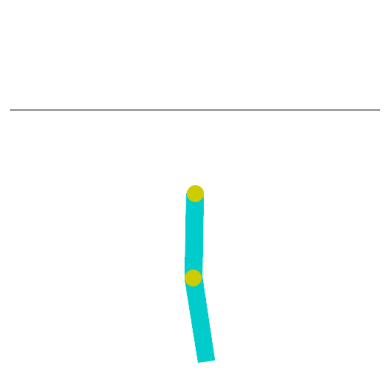

In [5]:
import gymnasium as gym
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Create the Acrobot-v1 environment with render mode 'rgb_array'
env = gym.make('Acrobot-v1', render_mode='rgb_array')

# Reset the environment to the initial state
state, _ = env.reset()

# Set up the figure and axis
fig, ax = plt.subplots()
img = env.render()
im = ax.imshow(img)
plt.axis('off')  # Turn off the axis

def update(frame):
    global state
    action = env.action_space.sample()  # Sample a random action
    state, reward, done, _, info = env.step(action)  # Take a step in the environment

    img = env.render()  # Render the environment and get the image
    im.set_array(img)  # Update the image data

    if done:
        state, _ = env.reset()  # Reset the environment if done

    return [im]

# Create the animation
ani = animation.FuncAnimation(fig, update, frames=200, blit=True, interval=50, repeat=True)

plt.show()

env.close()  # Close the environment